In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,-10.909884,level_180,level_347,level_455,level_421,level_209,level_37,level_319,level_242,level_418,...,level_28,level_210,level_305,level_208,level_78,level_489,level_230,level_198,level_46,level_492
1,-0.992645,level_73,level_339,level_163,level_420,level_486,level_206,level_24,level_346,level_350,...,level_470,level_440,level_275,level_186,level_402,level_95,level_470,level_98,level_381,level_399
2,5.321824,level_40,level_9,level_440,level_201,level_322,level_353,level_358,level_35,level_211,...,level_419,level_495,level_32,level_209,level_147,level_474,level_335,level_316,level_222,level_367
3,3.227198,level_408,level_35,level_159,level_14,level_423,level_499,level_285,level_424,level_163,...,level_112,level_247,level_51,level_163,level_179,level_385,level_499,level_490,level_374,level_26
4,5.612014,level_208,level_86,level_205,level_352,level_184,level_118,level_386,level_383,level_269,...,level_85,level_373,level_254,level_378,level_464,level_381,level_314,level_76,level_272,level_3


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-8.929678,2.234810,-5.777745,-24.165619,-5.499533,8.559812,3.783109,-1.652291,-4.621117,-18.726506,...,-0.668419,-7.630112,3.773026,1.615420,5.513181,2.579342,1.206824,-2.066881,1.193594,-8.848921
1,-2.194546,-4.706142,1.435322,3.976729,5.799674,7.061098,-0.707657,1.237143,3.804732,-0.596482,...,8.106357,9.903123,-1.660550,3.172825,-1.208820,0.958117,3.286718,-0.483123,4.196166,1.734937
2,-12.295649,-8.530008,-11.450828,8.952949,-1.368686,-0.859090,1.116057,-3.517338,-0.298822,-5.584676,...,-15.824280,4.227090,-5.878103,-4.439101,12.863300,-10.227191,1.840681,-6.484021,-5.407904,5.773041
3,0.821162,1.234075,15.497021,-2.812145,-3.669740,12.292224,0.748223,9.867270,-11.956880,-3.067089,...,6.198290,3.611241,2.984191,-10.783816,-1.267300,10.614109,12.804588,4.854240,5.377559,1.889550
4,11.711227,24.810746,9.198613,-12.758366,16.830005,12.077798,15.582066,3.116350,9.904919,23.013290,...,5.693083,3.302843,6.148456,-5.602759,8.637721,15.121028,15.807556,14.266874,10.388875,15.175248


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-7.113083,1.751772,-1.977141,-16.291274,-4.790598,5.911771,2.752892,-1.441355,-2.118702,-16.732429,...,-0.564569,-5.404630,2.688124,1.123718,2.471370,0.944985,0.396586,-0.902732,0.831961,-7.232936
1,-1.095586,-3.796825,0.923822,1.583845,3.609461,3.566864,-0.422681,1.182826,2.160795,-0.521134,...,6.853412,7.662397,-1.376127,2.165110,-0.446645,0.617304,1.678554,-0.307465,3.841895,1.423340
2,-4.993615,-6.802400,-8.460205,4.926481,-0.591957,-0.680829,0.966270,-2.928839,-0.275098,-3.517436,...,-8.427069,2.618047,-3.889636,-3.528657,6.316022,-6.048333,1.292411,-1.413448,-3.548608,4.635473
3,0.603976,0.759274,2.363665,-1.695655,-3.195579,8.394464,0.396579,6.263122,-7.146169,-1.440360,...,3.575040,2.107699,0.922569,-8.007767,-0.841055,6.842414,6.069485,2.933084,3.721660,0.981629
4,9.696886,19.606010,3.270291,-7.249953,11.901438,6.864803,9.505488,0.958227,4.242965,17.488777,...,3.647203,1.822912,2.315498,-2.738762,1.701223,6.572584,5.793869,8.688906,5.973809,7.818911


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-7.515835,1.562282,-3.155120e+00,-13.195260,-2.271496,10.019522,0.220792,0.368145,-13.705466,-17.931792,...,2.280602,-5.215773,4.323530e+00,1.777880,10.864131,1.233530,-4.983192e-01,1.958950e-01,2.391285,-8.257249
1,0.500510,-4.167086,1.197420e+00,15.892724,0.812908,0.000000,-0.203347,0.000000,-4.313321,2.079594,...,8.047030,11.872855,-1.110223e-16,2.598266,-0.373314,6.881838,2.987791e+00,-2.622368e+00,6.707049,-2.220422
2,-1.921943,-5.417391,-1.033676e+01,-0.294742,0.361438,6.052405,0.000000,-4.913562,0.441690,-1.401472,...,-5.222166,0.362302,-5.271689e+00,-5.255499,3.479119,-7.068887,2.624305e+00,-1.070814e+00,-4.238867,4.787532
3,0.790453,-3.066969,-5.551115e-17,-1.107930,-3.546377,9.741990,-0.001516,7.256316,-17.358247,-0.823007,...,4.812644,5.122119,0.000000e+00,-13.033727,-0.926836,5.431620,3.601932e+00,6.811534e+00,4.168464,0.770197
4,5.966633,0.000000,7.467153e-01,-19.321430,10.159990,1.758838,6.294208,-9.484366,1.414666,0.000000,...,1.243581,-1.325586,1.252577e-01,-6.514821,-0.203052,3.902497,-5.551115e-17,5.551115e-17,1.290108,5.674049


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.561388,0.537449,0.225763,0.184279,False
1,var_1_impact_code,0.541408,0.513873,0.163161,0.178189,False
2,var_2_impact_code,0.514326,0.486850,0.130094,0.191518,False
3,var_3_impact_code,0.525170,0.493544,0.132442,0.120860,False
4,var_4_impact_code,0.537242,0.508167,0.175747,0.157580,False
5,var_5_impact_code,0.539255,0.516836,0.186273,0.218927,False
6,var_6_impact_code,0.501895,0.472555,0.099389,0.149557,False
7,var_7_impact_code,0.524526,0.495332,0.153982,0.185214,False
8,var_8_impact_code,0.507986,0.481533,0.116056,0.145227,False
9,var_9_impact_code,0.548578,0.519275,0.201267,0.150918,False


(0.8381054968500248, 3.418251880794392e-30)


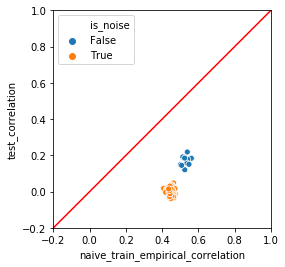

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8403949406835453, 1.689768908803988e-30)


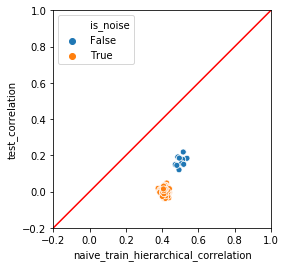

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8163025838383855, 1.6910007641688934e-27)


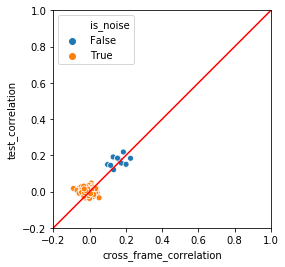

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
105,noise_95_impact_code,noise_95,impact_code,True,True,0.002583,0.898226,110.0,0.009091,False
106,noise_96_impact_code,noise_96,impact_code,True,True,0.005468,0.786578,110.0,0.009091,False
107,noise_97_impact_code,noise_97,impact_code,True,True,-0.009652,0.632724,110.0,0.009091,False
108,noise_98_impact_code,noise_98,impact_code,True,True,-0.020501,0.310038,110.0,0.009091,False
109,noise_99_impact_code,noise_99,impact_code,True,True,-0.029412,0.145238,110.0,0.009091,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,5.321824,8.015424,8.719090,2.332219,6.352564
1,5.612014,22.127453,15.502294,1.444345,3.575171
2,-12.785300,2.719209,6.470352,-2.571622,-4.625414
3,-20.297670,7.513373,3.480287,1.223695,3.493803
4,-30.858660,-0.931825,0.818024,2.396559,5.336053


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.1922383588073755


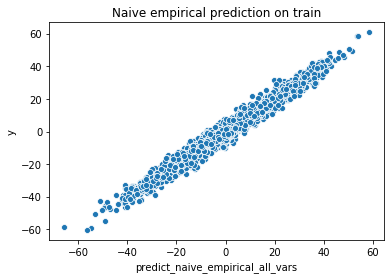

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.6959733853856775


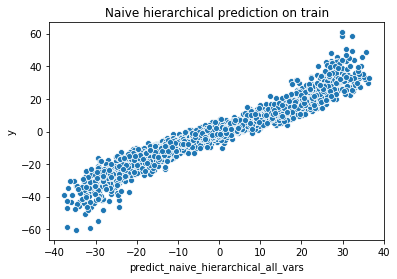

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.36154462619125


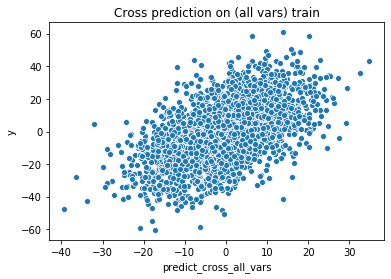

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.837575479725219


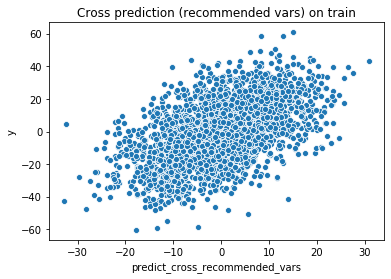

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.472934842454194


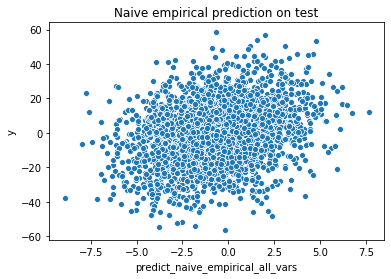

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.24679666676164


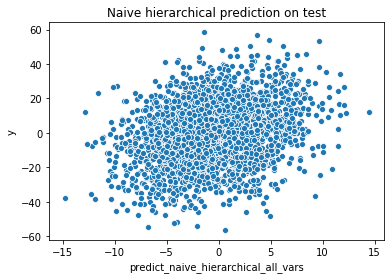

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.757533201024454


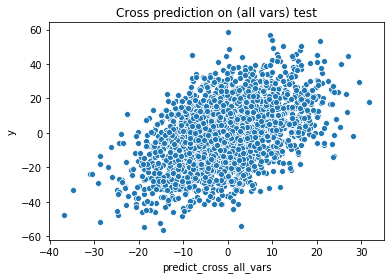

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.29893570860548


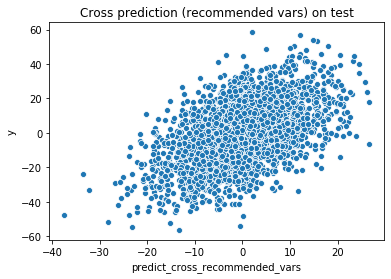

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

/Users/johnmount/anaconda3/envs/aiAcademy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     690.5
Date:                Sat, 07 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:27:22   Log-Likelihood:                -6330.5
No. Observations:                2454   AIC:                         1.288e+04
Df Residuals:                    2343   BIC:                         1.353e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.6424      0.066     -9.741      0.000      -0.772      -0.513
var_0_impact_code        0.0748      0.008      9.624      0.000       0.060       0.090
var_1_impact_code        0.0564      0.008      7.021      0.000       0.041       0.072
var_2_impact_code        0.0683      0.008      8.312      0.000       0.052       0.084
var_3_impact_code        0.0670      0.008      8.272      0.000       0.051       0.083
var_4_impact_code        0.0625      0.008      7.816      0.000       0.047       0.078
var_5_impact_code        0.0689      0.008      8.632      0.000       0.053       0.085
var_6_impact_code        0.0484      0.008      5.757      0.000       0.032       0.065
var_7_impact_code        0.0638      0.008      7.776      0.000       0.048       0.080
var_8_impact_code        0.0685      0.008      8.283      0.000       0.052       0.085
var_9_impact_code        0.0497      0.008      6.229      0.000       0.034       0.065
noise_0_impact_code      0.0484      0.009      5.343      0.000       0.031       0.066
noise_1_impact_code      0.0518      0.009      5.878      0.000       0.035       0.069
noise_2_impact_code      0.0285      0.009      3.165      0.002       0.011       0.046
noise_3_impact_code      0.0247      0.009      2.777      0.006       0.007       0.042
noise_4_impact_code      0.0347      0.009      3.837      0.000       0.017       0.052
noise_5_impact_code      0.0341      0.009      3.593      0.000       0.015       0.053
noise_6_impact_code      0.0420      0.009      4.714      0.000       0.025       0.060
noise_7_impact_code      0.0423      0.009      4.637      0.000       0.024       0.060
noise_8_impact_code      0.0349      0.009      4.002      0.000       0.018       0.052
noise_9_impact_code      0.0380      0.009      4.190      0.000       0.020       0.056
noise_10_impact_code     0.0379      0.009      4.286      0.000       0.021       0.055
noise_11_impact_code     0.0483      0.009      5.516      0.000       0.031       0.065
noise_12_impact_code     0.0482      0.009      5.187      0.000       0.030       0.066
noise_13_impact_code     0.0403      0.009      4.483      0.000       0.023       0.058
noise_14_impact_code     0.0342      0.009      3.768      0.000       0.016       0.052
noise_15_impact_code     0.0279      0.009      3.085      0.002       0.010       0.046
noise_16_impact_code     0.0454      0.010      4.634      0.000       0.026       0.065
noise_17_impact_code     0.0517      0.009      5.454      0.000       0.033       0.070
noise_18_impact_code     0.0364      0.009      3.939      0.000       0.018       0.054
noise_19_impact_code     0.0589      0.009      6.605      0.000       0.041       0.076
noise_20_impact_code     0.0436      0.009      4.750    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.97007517024404

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.05848430880075406

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

/Users/johnmount/anaconda3/envs/aiAcademy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     9.438
Date:                Sat, 07 Sep 2019   Prob (F-statistic):          4.36e-120
Time:                        09:27:22   Log-Likelihood:                -10186.
No. Observations:                2454   AIC:                         2.059e+04
Df Residuals:                    2343   BIC:                         2.124e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.6277      0.324     -1.938      0.053      -1.263       0.008
var_0_impact_code        0.5344      0.044     12.074      0.000       0.448       0.621
var_1_impact_code        0.4089      0.045      9.093      0.000       0.321       0.497
var_2_impact_code        0.3668      0.048      7.665      0.000       0.273       0.461
var_3_impact_code        0.3764      0.048      7.779      0.000       0.282       0.471
var_4_impact_code        0.4608      0.045     10.211      0.000       0.372       0.549
var_5_impact_code        0.4685      0.048      9.796      0.000       0.375       0.562
var_6_impact_code        0.3059      0.050      6.106      0.000       0.208       0.404
var_7_impact_code        0.4288      0.049      8.687      0.000       0.332       0.526
var_8_impact_code        0.3253      0.049      6.585      0.000       0.228       0.422
var_9_impact_code        0.5051      0.044     11.376      0.000       0.418       0.592
noise_0_impact_code      0.0961      0.057      1.676      0.094      -0.016       0.209
noise_1_impact_code      0.1064      0.056      1.889      0.059      -0.004       0.217
noise_2_impact_code      0.0102      0.057      0.177      0.859      -0.102       0.122
noise_3_impact_code     -0.0156      0.056     -0.280      0.780      -0.125       0.094
noise_4_impact_code      0.0166      0.055      0.301      0.763      -0.092       0.125
noise_5_impact_code     -0.1387      0.064     -2.161      0.031      -0.265      -0.013
noise_6_impact_code      0.0569      0.059      0.971      0.331      -0.058       0.172
noise_7_impact_code      0.0717      0.061      1.183      0.237      -0.047       0.191
noise_8_impact_code      0.0293      0.055      0.532      0.595      -0.079       0.137
noise_9_impact_code     -0.0022      0.057     -0.038      0.969      -0.114       0.110
noise_10_impact_code     0.0229      0.056      0.408      0.683      -0.087       0.133
noise_11_impact_code     0.0810      0.056      1.438      0.150      -0.029       0.191
noise_12_impact_code    -0.0908      0.058     -1.576      0.115      -0.204       0.022
noise_13_impact_code    -0.0338      0.058     -0.584      0.559      -0.147       0.080
noise_14_impact_code    -0.0364      0.059     -0.616      0.538      -0.152       0.080
noise_15_impact_code     0.0155      0.057      0.273      0.785      -0.095       0.126
noise_16_impact_code    -0.2315      0.060     -3.838      0.000      -0.350      -0.113
noise_17_impact_code    -0.0157      0.067     -0.235      0.814      -0.147       0.115
noise_18_impact_code    -0.1415      0.058     -2.445      0.015      -0.255      -0.028
noise_19_impact_code     0.0398      0.058      0.691      0.489      -0.073       0.153
noise_20_impact_code    -0.0914      0.059     -1.540    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.30703573672800044

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.23427591208103016

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

/Users/johnmount/anaconda3/envs/aiAcademy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     87.37
Date:                Sat, 07 Sep 2019   Prob (F-statistic):          2.92e-154
Time:                        09:27:22   Log-Likelihood:                -10261.
No. Observations:                2454   AIC:                         2.054e+04
Df Residuals:                    2443   BIC:                         2.061e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.5059      0.321     -1.576      0.115      -1.135       0.124
var_0_impact_code     0.5465      0.044     12.424      0.000       0.460       0.633
var_1_impact_code     0.4112      0.045      9.197      0.000       0.324       0.499
var_2_impact_code     0.3849      0.047      8.146      0.000       0.292       0.478
var_3_impact_code     0.3748      0.048      7.884      0.000       0.282       0.468
var_4_impact_code     0.4504      0.045     10.095      0.000       0.363       0.538
var_5_impact_code     0.4926      0.047     10.428      0.000       0.400       0.585
var_6_impact_code     0.3062      0.050      6.154      0.000       0.209       0.404
var_7_impact_code     0.4364      0.049      8.985      0.000       0.341       0.532
var_8_impact_code     0.3372      0.049      6.927      0.000       0.242       0.433
var_9_impact_code     0.4833      0.044     11.026      0.000       0.397       0.569
==============================================================================
Omnibus:                        0.573   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.751   Jarque-Bera (JB):                0.630
Skew:                           0.028   Prob(JB):                        0.730
Kurtosis:                       2.945   Cond. No.                         7.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.2634224805308565

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.2781976583304703